### Adversarial Trained Models Evaluation Metrics

In [112]:
# Eval metrics data paths
pretrained_evals = {'SQuAD': './eval_output', 'addCommon': './adv_addCommon/eval_output', 'addAny': './adv_addAny/eval_output', 'addSent': './adv_addSent/eval_output'}
fine_tuned_v1_evals = {'SQuAD': './new_eval_outputs/adv_combined/base_squad', 'addCommon': './new_eval_outputs/adv_combined/adv_addCommon', 'addAny': './new_eval_outputs/adv_combined/adv_addAny', 'addSent': './new_eval_outputs/adv_combined/adv_addSent'}
fine_tuned_v2_evals = {'SQuAD': './new_eval_outputs/adv_combined_v2/base_squad', 'addCommon': './new_eval_outputs/adv_combined_v2/adv_addCommon', 'addAny': './new_eval_outputs/adv_combined_v2/adv_addAny', 'addSent': './new_eval_outputs/adv_combined_v2/adv_addSent'}


#### Base vs Adversarial Sets Only vs Combined Sets Model F1

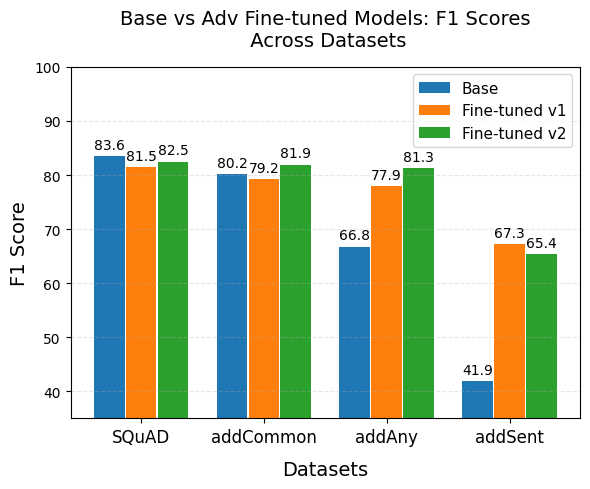

In [113]:
import json
import matplotlib.pyplot as plt

def plot_metric_results(metric, title, yLabel, label_format="%.1f", ylim=(35, 100)):
    # Load the data from the JSON files
    def load_scores(eval_paths):
        scores = {}
        for key, path in eval_paths.items():
            with open(f"{path}/eval_metrics.json", 'r') as file:
                data = json.load(file)
                if metric == 'eval_bleu':
                    scores[key] = data[metric]['bleu']
                elif data[metric] is not None:
                    scores[key] = data[metric]
                else:
                    print(f"Metric {metric} not found in {path}/eval_metrics.json")
        return scores

    pretrained_scores = load_scores(pretrained_evals)
    fine_tuned_v1_scores = load_scores(fine_tuned_v1_evals)
    fine_tuned_v2_scores = load_scores(fine_tuned_v2_evals)

    # Define the datasets
    datasets = list(pretrained_evals.keys())

    # Plot the F1 scores
    fig, ax = plt.subplots(figsize=(6, 5))
    bar_width = 0.25
    padding = 0.01
    index = range(len(datasets))

    bar1 = plt.bar([i - bar_width - padding for i in index], [pretrained_scores[dataset] for dataset in datasets], bar_width, label='Base')
    bar2 = plt.bar([i for i in index], [fine_tuned_v1_scores[dataset] for dataset in datasets], bar_width, label='Fine-tuned v1')
    bar3 = plt.bar([i + bar_width + padding for i in index], [fine_tuned_v2_scores[dataset] for dataset in datasets], bar_width, label='Fine-tuned v2')

    # Add labels for each bar
    plt.bar_label(bar1, padding=3, fontsize=10, fmt=label_format)
    plt.bar_label(bar2, padding=3, fontsize=10, fmt=label_format)
    plt.bar_label(bar3, padding=3, fontsize=10, fmt=label_format)

    # Add titles and labels
    plt.xlabel('Datasets', fontsize=14, labelpad=10)
    plt.ylabel(yLabel, fontsize=14)
    plt.title(title, fontsize=14, pad=15)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.ylim(ylim)
    plt.xticks([i for i in index], datasets, fontsize=12)
    plt.legend(fontsize=11)  # Increase the font size of the legend


    plt.tight_layout()
    plt.show()

plot_metric_results(metric='eval_f1', yLabel="F1 Score", title='Base vs Adv Fine-tuned Models: F1 Scores\n Across Datasets')

#### Blue Scores Evaluated across Models vs Datasets

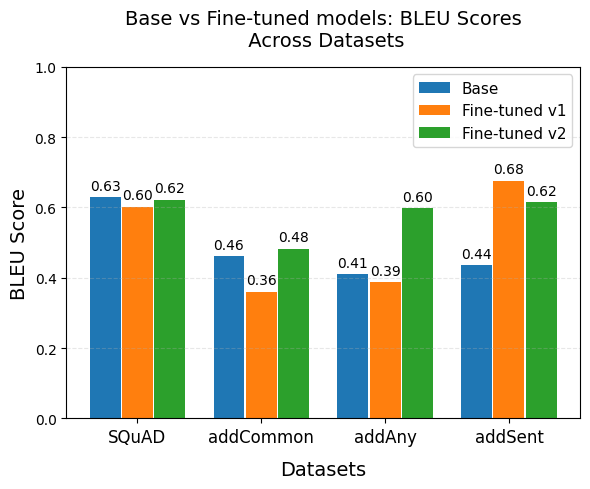

In [114]:
plot_metric_results(metric='eval_bleu', ylim=(0, 1), label_format="%.2f", yLabel="BLEU Score", title='Base vs Fine-tuned models: BLEU Scores\n Across Datasets')

##### Classify errors made by Fine-tuned_v2

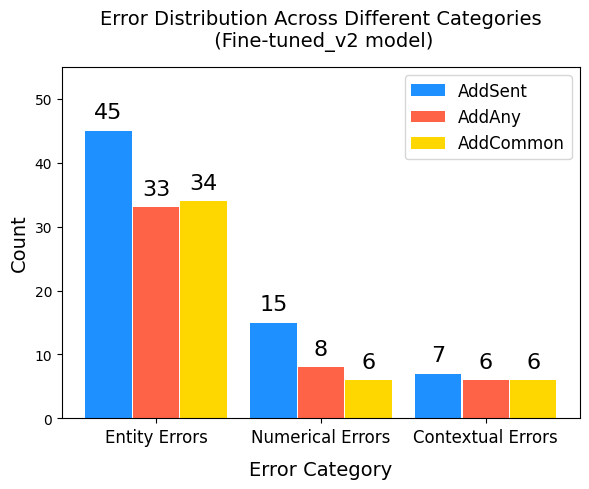

In [115]:
import numpy as np
import json
import matplotlib.pyplot as plt

# Data for AddSent, AddAny, and AddCommon
categories_addSent_v2 = {
    "Entity Errors": [],
    "Numerical Errors": [],
    "Contextual Errors": []
}
categories_addAny_v2 = {
    "Entity Errors": [],
    "Numerical Errors": [],
    "Contextual Errors": []
}
categories_addCommon_v2 = {
    "Entity Errors": [],
    "Numerical Errors": [],
    "Contextual Errors": []
}

# Define the categories
category_names_addSent = categories_addSent_v2.keys()

# Function to classify errors
def classify_error(example):
    question = example["question"].lower()
    predicted_answer = example["predicted_answer"].lower()
    correct_answers = [answer.lower() for answer in example["answers"]["text"]]

    # Check for numerical errors
    if any(char.isdigit() for char in predicted_answer):
        return "Numerical Errors"

    # Check for entity errors
    if any(entity in question for entity in ["where", "who", "what", "which", "when"]):
        return "Entity Errors"
    
    # Default to contextual errors
    return "Contextual Errors"

# Function to classify each example
def classify_example(path, categories):
    # Read the JSONL file and classify each example for AddOneSent
    with open(path, 'r') as file:
        for line in file:
            example = json.loads(line)
            category = classify_error(example)
            categories[category].append(example)

classify_example('./new_eval_outputs/adv_combined_v2/addSent_incorrect_pred.jsonl', categories_addSent_v2)
classify_example('./new_eval_outputs/adv_combined_v2/addAny_incorrect_pred.jsonl', categories_addAny_v2)
classify_example('./new_eval_outputs/adv_combined_v2/addCommon_incorrect_pred.jsonl', categories_addCommon_v2)

counts_addSent = [len(examples) for examples in categories_addSent_v2.values()]
counts_addAny = [len(examples) for examples in categories_addAny_v2.values()]
counts_addCommon = [len(examples) for examples in categories_addCommon_v2.values()]

# Create grouped bar chart with padding
x = np.arange(len(category_names_addSent))  # the label locations
width = 0.35  # the width of the bars
padding = 0.01  # padding between bars

fig, ax = plt.subplots(figsize=(6, 5))
# Adjust x to add padding between groups
x = np.arange(len(category_names_addSent)) * (width * 3 + padding * 20)

bars1 = ax.bar(x - width - padding, counts_addSent, width, label='AddSent', color='dodgerblue')
bars2 = ax.bar(x, counts_addAny, width, label='AddAny', color='tomato')
bars3 = ax.bar(x + width + padding, counts_addCommon, width, label='AddCommon', color='gold')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Error Category', fontsize=14, labelpad=10)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Error Distribution Across Different Categories\n (Fine-tuned_v2 model)', fontsize=14, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(category_names_addSent, fontsize=12)
ax.legend(fontsize=12)

# Add labels for each bar
plt.bar_label(bars1, padding=6, fontsize=16)
plt.bar_label(bars2, padding=6, fontsize=16)
plt.bar_label(bars3, padding=6, fontsize=16)

plt.tight_layout()
plt.ylim(0, 55)
plt.show()

#### Difference in Errors between Base & Fine-tuned_v2 model (across adv datasets)

{'addSent': {'Entity Errors': -24, 'Numerical Errors': -8, 'Contextual Errors': 0}, 'addAny': {'Entity Errors': -12, 'Numerical Errors': -7, 'Contextual Errors': 1}, 'addCommon': {'Entity Errors': 1, 'Numerical Errors': -1, 'Contextual Errors': 0}}


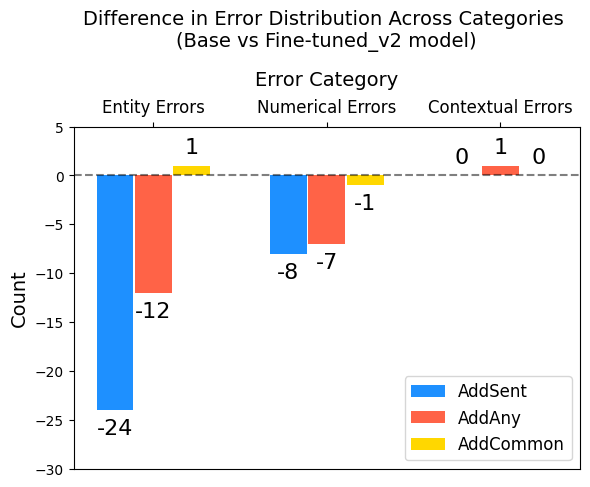

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Data for AddSent, AddAny, and AddCommon
categories_base = {
    "addSent": { "Entity Errors": 0, "Numerical Errors": 0, "Contextual Errors": 0 },
    "addAny": { "Entity Errors": 0, "Numerical Errors": 0, "Contextual Errors": 0 },
    "addCommon": { "Entity Errors": 0, "Numerical Errors": 0, "Contextual Errors": 0 }
}
categories_fine_tuned_v2 = {
    "addSent": { "Entity Errors": 0, "Numerical Errors": 0, "Contextual Errors": 0 },
    "addAny": { "Entity Errors": 0, "Numerical Errors": 0, "Contextual Errors": 0 },
    "addCommon": { "Entity Errors": 0, "Numerical Errors": 0, "Contextual Errors": 0 }
}

# Count the number of errors in each category for the base model
for category in categories_base.keys():
    for error_type in categories_base[category].keys():
        with open(f'./error_analysis/{category}_error_classes/{error_type.lower().replace(" ", "_")}.jsonl', 'r') as file:
            count = 0
            for line in file:
                count += 1
            categories_base[category][error_type] = count

# Count the number of errors in each category for the fine-tuned model
for category in categories_fine_tuned_v2.keys():
    for error_type in categories_fine_tuned_v2[category].keys():
        with open(f'./new_eval_outputs/adv_combined_v2/{category}_incorrect_pred.jsonl', 'r') as file:
            count = 0
            for line in file:
                example = json.loads(line)
                if classify_error(example) == error_type:
                    count += 1
            categories_fine_tuned_v2[category][error_type] = count

# Find the differences in the error counts between the base and fine-tuned models
differences = {}
for category in categories_base.keys():
    differences[category] = {}
    for error_type in categories_base[category].keys():
        differences[category][error_type] = categories_fine_tuned_v2[category][error_type] - categories_base[category][error_type]

print(differences)

counts_addSent = [differences["addSent"][error_type] for error_type in categories_base["addSent"].keys()]
counts_addAny = [differences["addAny"][error_type] for error_type in categories_base["addAny"].keys()]
counts_addCommon = [differences["addCommon"][error_type] for error_type in categories_base["addCommon"].keys()]

# Create grouped bar chart with padding
x = np.arange(3)  # the label locations
width = 0.35  # the width of the bars
padding = 0.015  # padding between bars

fig, ax = plt.subplots(figsize=(6, 5))
# Adjust x to add padding between groups
x = np.arange(3) * (width * 3 + padding * 40)

bars1 = ax.bar(x - width - padding, counts_addSent, width, label='AddSent', color='dodgerblue')
bars2 = ax.bar(x, counts_addAny, width, label='AddAny', color='tomato')
bars3 = ax.bar(x + width + padding, counts_addCommon, width, label='AddCommon', color='gold')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Error Category', fontsize=14, labelpad=10)
ax.set_ylabel('Count', fontsize=14)
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.set_title('Difference in Error Distribution Across Categories \n(Base vs Fine-tuned_v2 model)', fontsize=14, pad=17)
ax.set_xticks(x)
ax.tick_params(axis='x', top=True, labeltop=True, labelbottom=False, bottom=False)
ax.set_xticklabels(category_names_addSent, fontsize=12)
ax.legend(fontsize=12, loc='lower right')

# Add labels for each bar
plt.bar_label(bars1, padding=6, fontsize=16)
plt.bar_label(bars2, padding=6, fontsize=16)
plt.bar_label(bars3, padding=6, fontsize=16)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5) # Add a horizontal line at y=0
plt.tight_layout()
plt.ylim(-30, 5)

plt.show()

#### Base vs Fine-tuned_v2 model: BLEU Precision Scores across datasets

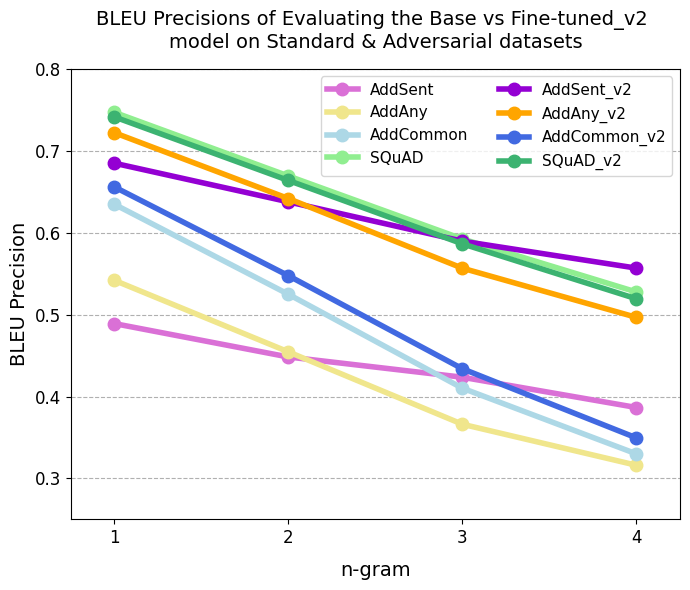

In [119]:
# BLEU Precisions for AddSent, AddAny, and AddCommon
precisions_base = {
    "addSent": [],
    "addAny": [],
    "addCommon": [],
}
precisions_fine_tuned_v2 = {
    "addSent": [],
    "addAny": [],
    "addCommon": [],
}

# Load the BLEU precisions for the base model from the eval_metrics.json files
for category in precisions_base.keys():
    with open(f'./adv_{category}/eval_output/eval_metrics.json', 'r') as file:
        data = json.load(file)
        precisions_base[category] = data['eval_bleu']['precisions']
with open('./eval_output/eval_metrics.json', 'r') as file:
    data = json.load(file)
    precisions_base["base_squad"] = data['eval_bleu']['precisions']

# Load the BLEU precisions for the fine-tuned model from the eval_metrics.json files
for category in precisions_fine_tuned_v2.keys():
    with open(f'./new_eval_outputs/adv_combined_v2/adv_{category}/eval_metrics.json', 'r') as file:
        data = json.load(file)
        precisions_fine_tuned_v2[category] = data['eval_bleu']['precisions']
with open('./new_eval_outputs/adv_combined_v2/base_squad/eval_metrics.json', 'r') as file:
    data = json.load(file)
    precisions_fine_tuned_v2["base_squad"] = data['eval_bleu']['precisions']

# Data for plotting
labels = ['AddSent', 'AddAny', 'AddCommon', 'SQuAD', 'AddSent_v2', 'AddAny_v2', 'AddCommon_v2', 'SQuAD_v2']
bleu_precisions = []
for category in precisions_base.keys():
    bleu_precisions.append(precisions_base[category])
for category in precisions_fine_tuned_v2.keys():
    bleu_precisions.append(precisions_fine_tuned_v2[category])
n_grams = [1, 2, 3, 4]

# Create line chart
plt.figure(figsize=(7, 6))
colors = ['orchid', 'khaki', 'lightblue','lightgreen', 'darkviolet', 'orange',  'royalblue', 'mediumseagreen']  # Define colors for each dataset
for precisions, color, label in zip(bleu_precisions, colors, labels):
    plt.plot(n_grams, precisions, marker='o', linestyle='-', markersize=9, linewidth=4, label=label, color=color)

plt.xlabel('n-gram', fontsize=14, labelpad=10)
plt.ylabel('BLEU Precision', fontsize=14)
plt.title('BLEU Precisions of Evaluating the Base vs Fine-tuned_v2 \nmodel on Standard & Adversarial datasets', fontsize=14, pad=15)

# Add BLEU precision values on the markers
# for dataset, precisions in zip(datasets, bleu_precisions):
#     for n, precision in zip(n_grams, precisions):
#         if dataset == datasets[-1]:  # Check if it's the bottom most dataset
#             plt.text(n, precision - 0.03, f'{precision:.2f}', ha='center', va="top", fontsize=14)
#         else:
#             plt.text(n, precision + 0.03, f'{precision:.2f}', ha='center', va="bottom", fontsize=14)

plt.xticks(n_grams, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=11, ncol=2, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=1)
plt.ylim(0.25, 0.8)  # Adjust the y-axis limit if needed
plt.xlim(0.75, 4.25)  # Adjust the x-axis limit if needed
plt.tight_layout()
plt.show()